<h1>Image Colorizer *Very work in progress*</h1><hr>
<h3>Jason Lombino - Capstone Project Submission</h3>

<h1>Business Proposal</h1>

BentoColor is a company with the goal of colorizing old movies & television shows for remastered releases.

Better than paying artists to fumble through the hundreds of thousands of frames in a movie or season of a television show and even if it isnt perfect it can serve as a good starting off point for each frame that needs to be colored.

<h1>Part 1: Getting Colorization Working</h1>

<h3>Why Neural Networks?</h3>

This is a transformative problem, not just a simple regression or classification so it needs the extreme robustness that can only be provided by a neural network. Convolutional neural networks are also the de-facto standard for working with data in image format so there is a lot of wisdom/experience/technical papers to draw on when solving problems.

<h3>Selected Architecture</h3>

The generator used to create the image colorizer is a modified U-NET based on this paper: https://arxiv.org/abs/1611.07004 this paper https://arxiv.org/abs/1505.04597 and this tensorflow tutorial: https://www.tensorflow.org/tutorials/generative/pix2pix

The downsampling stack resembles a normal convolutional neural network extracting features from the input image. The upsampling stack re-expands the features selected by the downsampling stack back to a full resolution image. The skip connections help the upsampling layers more precicely determine the location of larger features.

<h3>Data and Sources</h3>

The dataset used to develop the first iteration can be found on kaggle:

https://www.kaggle.com/datasets/utkarshsaxenadn/landscape-recognition-image-dataset-12k-images

This dataset contains 12,000 images of various types of landscape. There are 10,000 images in the training set, 1,500 in the validation set, and 500 images in the test set. 

Due to a lack of computing power, both the images and the dataset as a whole needed to be relatively small. Therefore, images were downscaled to 64 x 64 pixels, and the dataset was chosen to be a cohesive set of images rather than random images of various topics. While it is certainly possible to build a colorizer that works on larger and more varied images, that colorizer would take too long to reasonably train and iterate on without the appropriate computer hardware.

<h3>Training Methodology and GANs</h3>

This is a really hard problem because if i showed you a shoe what color would you make it? A tree can be different colors depending on the season. The neural network will need to be able to generalize really well to capture these scenarios and colorize them to the best of its ability. It also needs to be able to tell that something is a tree in the first place or at least recognize that the pattern of pixels that looks like a tree is usually green before it can decide what color anything should actually be.

Testing two methods of training the neural network generator. The first is a traditional mean squared error (MSE) approach where you just tell the neural network to minimize the difference between the training black and white frame and its corresponding colored frame. This can be promising, but might have a tendency to overfit to the training data as neural networks do meaning it would generalize less well when compared to the next training method. It will likely also produce less vibrant results because it is penalized more for being very different from the source picture even if it could theoretically have colored well. 

A GAN is trained completely differently than a normal neural network because it introduces an entirely new neural network into the picture to do the training. The generator will color some images and the new neural network the discriminator will try to tell whether a given image was colored by the generator or colored already as part of the training set. The two will fight where the generator tries to trick the discriminator and the discriminator tries to stay one step ahead of the generator. This training will continue until the generator's colored images are virtually indistinguishable from the originally colored images.

This introduces some problems though. First off it involves another neural network so it is more computationally expensive to train. Second, the generator and discriminator have to be carefully tuned so that neither of them has such an advantage that the other one cant fool it or learn. Third, the generator can sometimes go off in its own direction and never converge to something the discriminator would be fooled by. This third problem can be somewhat mitigated by combining the traditional method of training the generator (MSE) with the GAN loss.

The main advantage of this is that the generator is not tied down to trying to replicate the original images exactly and can take some "artistic liberties" when generating the new colored images. As long as the discriminator can't tell whether an image is part of the originally colored set or the generator colored set, the training is considered a success.

<p style='color:red'>ADD DIAGRAMS and other stuff where relevant</p>

<h1>Results</h1>

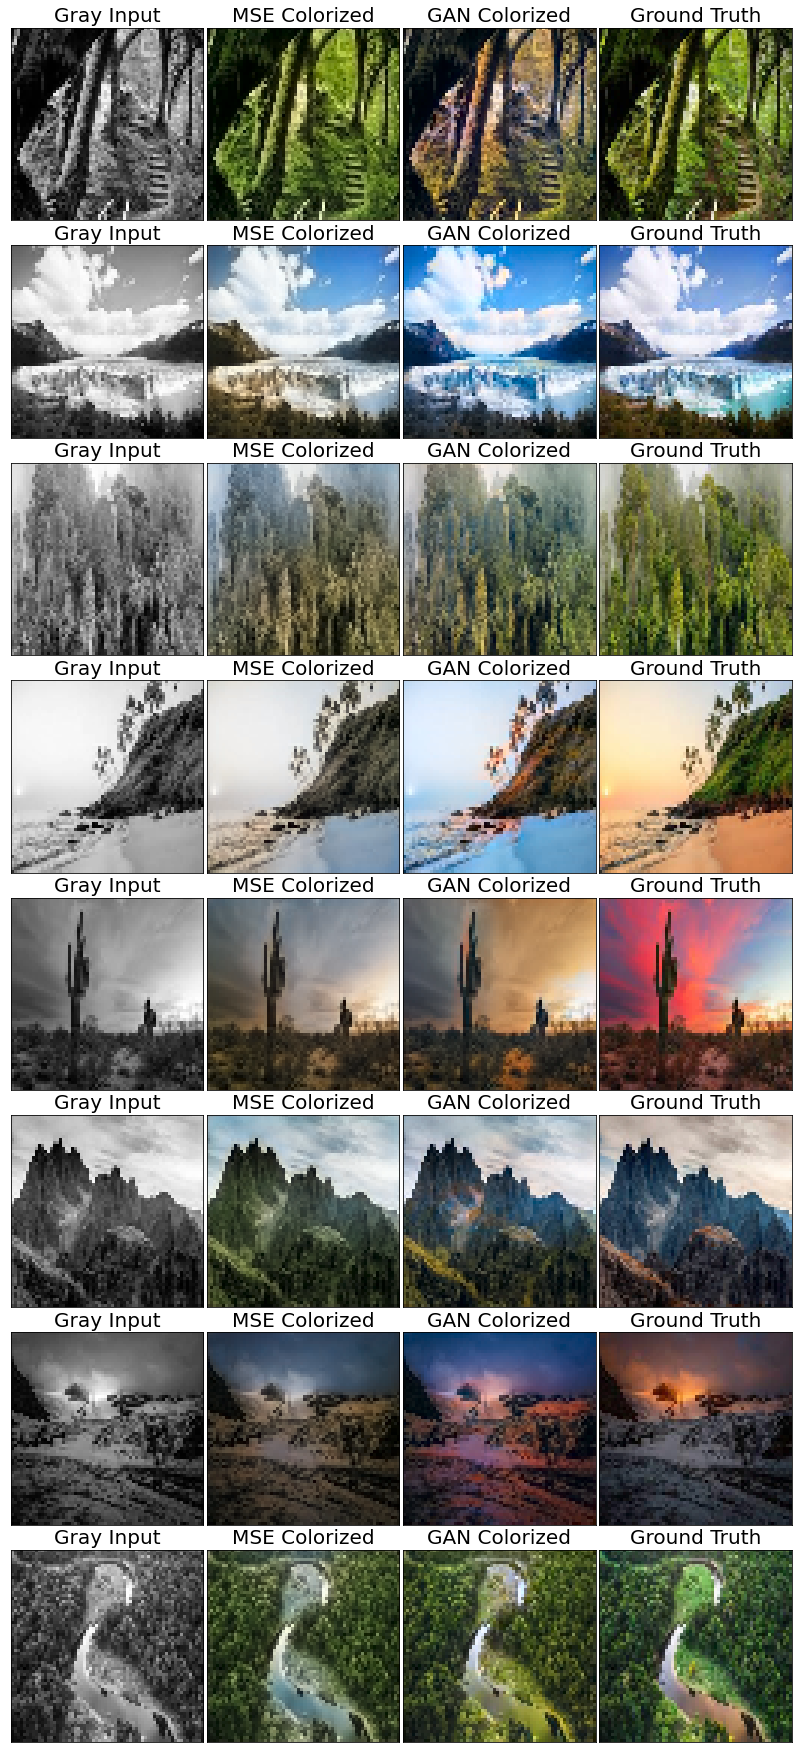

In [1]:
import colorizerutils as utils
from tensorflow.keras.models import load_model

mse_gen = load_model('models/1-5-23/mse/generator.h5')
gan_gen = load_model('models/1-5-23/gan/generator.h5')

for test_batch in range(1):
    test_images = utils.image_loader(directory='../images/test_images/',
     batch_size=8,training=False).__getitem__(test_batch)
    utils.display_images(gray_channel=test_images[0],color_channels=test_images[1],
    generator1=mse_gen,gen1_title='MSE Colorized',generator2=gan_gen,gen2_title='GAN Colorized');

<h1>Part 2: Applying to Movies and TV Shows</h1>

<h3>Selected Architecture</h3>

<h3>Data and Sources</h3>

<h3>Training Methodology</h3>


In [2]:
import imageio
import numpy as np

test_folder = '../shows/episode7/'
save_folder = 'resources/video/'

dusty_gen = load_model('models/1-9-23/dusty/generator.h5')

In [3]:
grayscale_frames = []
colorized_frames = []
original_frames = []

# 256 Frames is roughly 30 seconds of video
test_batch_1 = utils.image_loader(directory=test_folder,
    batch_size=128,training=False,sort_files=True).__getitem__(2)

train_output = dusty_gen(test_batch_1[0],training=False)

for frame_number, gray_frame in enumerate(test_batch_1[0]):

    grayscale_dummy_color = np.dstack([np.zeros_like(gray_frame),
        np.zeros_like(gray_frame)])

    grayscale_frames.append(utils.lab_to_rgb_combine_channels(
        l_channel=gray_frame,
        ab_channels=grayscale_dummy_color
    ))

    colorized_frames.append(utils.lab_to_rgb_combine_channels(
        l_channel=gray_frame,
        ab_channels=train_output[frame_number]
    ))

    original_frames.append(utils.lab_to_rgb_combine_channels(
        l_channel=gray_frame,
        ab_channels = test_batch_1[1][frame_number]
    ))

with imageio.get_writer(save_folder + 'test_1_grayscale.gif',mode='I',fps=8) as writer:
    for frame in grayscale_frames:
        writer.append_data(frame)

with imageio.get_writer(save_folder + 'test_1_colorized.gif',mode='I',fps=8) as writer:
    for frame in colorized_frames:
        writer.append_data(frame)

with imageio.get_writer(save_folder + 'test_1_original.gif',mode='I',fps=8) as writer:
    for frame in original_frames:
        writer.append_data(frame)

<img src=resources/video/test_1_grayscale.gif width=256></img>
<img src=resources/video/test_1_colorized.gif width=256></img>
<img src=resources/video/test_1_original.gif width=256></img>

In [4]:
grayscale_frames = []
colorized_frames = []
original_frames = []

# 256 Frames is roughly 30 seconds of video
test_batch_2 = utils.image_loader(directory=test_folder,
    batch_size=128,training=False,sort_files=True).__getitem__(17)

train_output = dusty_gen(test_batch_2[0],training=False)

for frame_number, gray_frame in enumerate(test_batch_2[0]):

    grayscale_dummy_color = np.dstack([np.zeros_like(gray_frame),
        np.zeros_like(gray_frame)])

    grayscale_frames.append(utils.lab_to_rgb_combine_channels(
        l_channel=gray_frame,
        ab_channels=grayscale_dummy_color
    ))

    colorized_frames.append(utils.lab_to_rgb_combine_channels(
        l_channel=gray_frame,
        ab_channels=train_output[frame_number]
    ))

    original_frames.append(utils.lab_to_rgb_combine_channels(
        l_channel=gray_frame,
        ab_channels = test_batch_2[1][frame_number]
    ))

with imageio.get_writer(save_folder + 'test_2_grayscale.gif',mode='I',fps=8) as writer:
    for frame in grayscale_frames:
        writer.append_data(frame)

with imageio.get_writer(save_folder + 'test_2_colorized.gif',mode='I',fps=8) as writer:
    for frame in colorized_frames:
        writer.append_data(frame)

with imageio.get_writer(save_folder + 'test_2_original.gif',mode='I',fps=8) as writer:
    for frame in original_frames:
        writer.append_data(frame)

<img src=resources/video/test_2_grayscale.gif width=256></img>
<img src=resources/video/test_2_colorized.gif width=256></img>
<img src=resources/video/test_2_original.gif width=256></img>

<h1>Conclusion and Future Work</h1>

Larger Images?
Different topics?

Success?